## Model evaluation

Multi-class classification: stars from 1 to 5

In [ ]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Unicode
using Random

In [ ]:
using Revise
#using TokenizersLite # https://github.com/LiorSinai/TokenizersLite
using TransformersLite

In [ ]:
include("../../common/reporting.jl")
include("../../common/vocab.jl")
include("../../common/training.jl")

update_history! (generic function with 1 method)

In [ ]:
nlabels = 5

5

## Download data

Run `python download_amazon_reviews.py`.

Requires Python and the `datasets` package by HuggingFace.

## Load data

raw

In [ ]:
fingerprint = "724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609"
data_dir = joinpath("..\\datasets\\amazon_reviews_multi\\en\\1.0.0\\", fingerprint)
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
filepath = joinpath(data_dir, file_train)
df = DataFrame(Arrow.Table(filepath))
println("rows: ", nrow(df))

filepath = joinpath(data_dir, file_test)
df_test = DataFrame(Arrow.Table(filepath));
println("rows: ", nrow(df_test))

rows: 200000
rows: 5000


filtered

In [ ]:
documents = df[:, :review_body]
labels = df[:, :stars]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


In [ ]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [ ]:
directory = "outputs/20230819_1304_n5_none_diff_vocab"
saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 3 entries:
  :tokenizer => identity
  :indexer   => IndexTokenizer{String}(length(vocabulary)=6996, unksym=[UNK])
  :model     => TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{…

In [ ]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
model = saved_objects[:model]
display(model)

tokenizer = identity
indexer = IndexTokenizer{String}(length(vocabulary)=6996, unksym=[UNK])


TransformerClassifier(
  Embed((32, 6996)),                    # 223_872 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(50 => 5),                       # 255 parameters
)        # Total: 21 trainable arrays, 236_864 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1.027 MiB.

In [ ]:
max_sentence_length = size(model.classifier.weight, 2)

50

## Tokenizers

In [ ]:
@time tokens = map(d->preprocess(d, tokenizer; max_length=max_sentence_length), documents)
@time indices = indexer(tokens) #takes about 12 seconds for all documents

y_train = copy(labels)
idxs = Base.OneTo(length(labels))
X_train, y_train = indices[:, idxs], y_train[idxs];
y_train = Flux.onehotbatch(y_train, 1:5) # multi-class
train_data, val_data = split_validation(MersenneTwister(2718), X_train, y_train)

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

  5.386918 seconds (28.36 M allocations: 1.760 GiB, 15.39% gc time, 3.34% compilation time)
 22.825344 seconds (30.15 k allocations: 79.860 MiB, 0.21% gc time, 0.35% compilation time)
train samples:      (50, 180000) (5, 180000)
validation samples: (50, 20000) (5, 20000)


In [ ]:
y_test = copy(labels_test)
y_test = Flux.onehotbatch(y_test, 1:5);

@time tokens_test = map(d->preprocess(d, tokenizer; max_length=max_sentence_length), documents_test) 
@time indices_test = indexer(tokens_test)

X_test = indices_test

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.385018 seconds (733.48 k allocations: 46.635 MiB, 8.85% gc time, 39.81% compilation time)
  0.586727 seconds (5 allocations: 1.946 MiB)
test indices: (50, 5000)
test samples: (50, 5000) (5, 5000)


In [ ]:
train_data_loader = DataLoader(train_data; batchsize=64, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=64, shuffle=false);

## Evaluate

In [ ]:
loss(ŷ::AbstractMatrix, y::AbstractMatrix) = Flux.logitcrossentropy(ŷ, y)
accuracy(ŷ::AbstractMatrix, y::AbstractMatrix) = mean(Flux.onecold(ŷ) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [ ]:
@time batched_metrics(model, train_data_loader, loss, accuracy)

 52.333287 seconds (10.67 M allocations: 55.559 GiB, 9.17% gc time, 11.43% compilation time)


(loss = 1.0195078f0, accuracy = 0.55714446f0)

In [ ]:
@time batched_metrics(model, val_data_loader, loss, accuracy)

  7.430135 seconds (77.80 k allocations: 6.103 GiB, 9.89% gc time)


(loss = 1.096968f0, accuracy = 0.5159f0)

In [ ]:
history = open(joinpath(directory, "history.json"), "r") do f
    JSON.parse(read(f, String))
end

Dict{String, Any} with 5 entries:
  "train_loss"      => Any[1.20734, 1.14205, 1.10393, 1.08438, 1.08363, 1.05769…
  "train_acc"       => Any[0.464889, 0.496061, 0.515939, 0.525806, 0.526239, 0.…
  "mean_batch_loss" => Any[1.38905, 1.20058, 1.15427, 1.12848, 1.11155, 1.09983…
  "val_acc"         => Any[0.4641, 0.4937, 0.50405, 0.51255, 0.51125, 0.5135, 0…
  "val_loss"        => Any[1.21332, 1.15334, 1.12749, 1.11324, 1.12302, 1.10485…

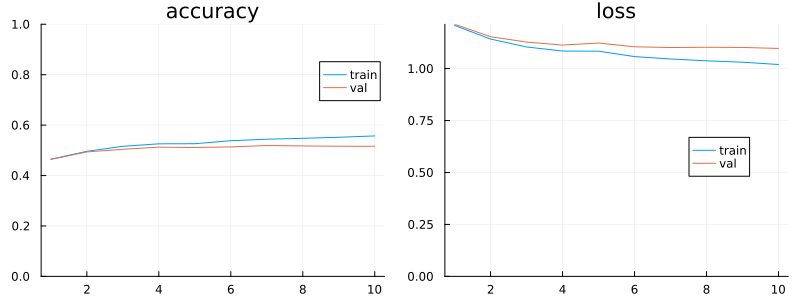

In [ ]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.8))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [ ]:
logits = model(X_test)
accuracy(logits, y_test)

0.5172

In [ ]:
probs = softmax(logits, dims=1)
y_pred = Flux.onecold(probs);

In [ ]:
cm = confusion_matrix(vec(y_pred), Flux.onecold(y_test), 1:nlabels)

5×5 Matrix{Int64}:
 671  219   57   20   33
 264  399  220   79   38
 128  241  331  239   61
  23   65  177  474  261
  25   31   29  204  711

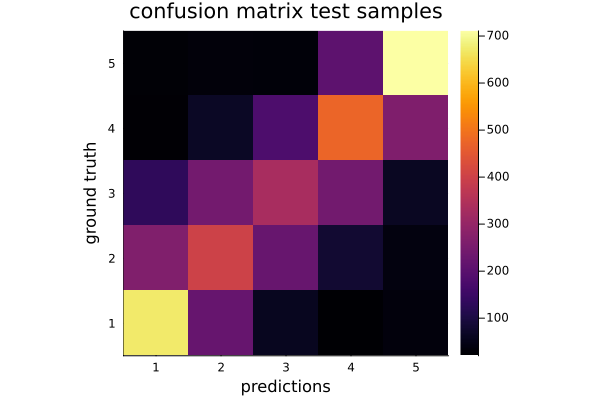

In [ ]:
p = heatmap(1:5, 1:5, cm, xlabel="predictions", ylabel="ground truth", xlims=(0.5, nlabels+0.5), aspectratio=1,
    title="confusion matrix test samples", xticks=(1:5)) #, ["negative", "mix", "positive"]))
savefig(p, joinpath(directory, "confusion_matrix.png"))
p

In [ ]:
classification_report(cm, 1:nlabels)

              precision  recall  f1-score  support
           1       0.60    0.67      0.64     1000
           2       0.42    0.40      0.41     1000
           3       0.41    0.33      0.36     1000
           4       0.47    0.47      0.47     1000
           5       0.64    0.71      0.68     1000

weighted avg       0.51    0.52      0.51     5000

### Examples

In [ ]:
println("star  y  ŷ   prob")
for star in nlabels:-1:1
    pos_max = argmax(probs[star, :])
    @printf("   %1d  %d  %d  %.4f  %s\n\n",
            star, labels_test[pos_max], y_pred[pos_max], probs[star, pos_max], documents_test[pos_max]
        )
end

star  y  ŷ   prob
   5  5  5  0.9760  This book was so amazing!! WOW!! This is my favorite book that I have read in such a long time. It is a great summer read and it has made me wish that I could be a Meade Creamery girl myself!! Siobhan is an awesome writer and I can’t wait to read more from her.

   4  4  4  0.8684  Great product. Only complaint I have was in packaging some paints did leak. Otherwise excellent!

   3  2  3  0.6267  One of my glasses came chipped, I ordered the amount that I did for a reason and now I am short one. Very very annoyed that one was chipped. But the 5 that were okay I really like.

   2  1  2  0.6350  I bought this product and thought it was awesome in the box but when I shot it I discovered it jammed frequently and pinches you at the top unless your very careful and after about 10 ft the pellet curves upward severely. After it fell from a barely 2 ft tall coffee table it broke and would not cock Iv also noticed after reading a lot of reviews that this i

In [ ]:
nshow = 2

for label in 1:nlabels
    println("\ntrue label = $label")
    idxs = labels_test .== label
    idxs_label = (1:length(labels_test))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            println("-"^100)
            @printf("%4d  %d  %d  %.4f  %s\n",
                idx, labels_test[idx], y_pred[idx], probs[idx], documents_test[idx]
            )
        end
    end
    println("")
end


true label = 1
correct: 671 / 1000
 idx  y  ŷ    prob  
----------------------------------------------------------------------------------------------------
 343  1  1  0.0262  Repair looks like crap and they will not take returns! Stay away and don't waste your money here.
----------------------------------------------------------------------------------------------------
 972  1  1  0.3243  What can I say...I read the reviews. I knew the risks. My son really* wanted a red boombox. The thing stopped working after 2 weeks of playing. I pulled it out the other day because I needed a boombox and low and behold.....it still didn't work. Trust me, avoid this boombox!
----------------------------------------------------------------------------------------------------
  11  1  4  0.5695  Really, really thin.
----------------------------------------------------------------------------------------------------
 165  1  2  0.0071  Sadly, really doesn't seem to work worth a darn. Maybe is the pa

### Probabilities

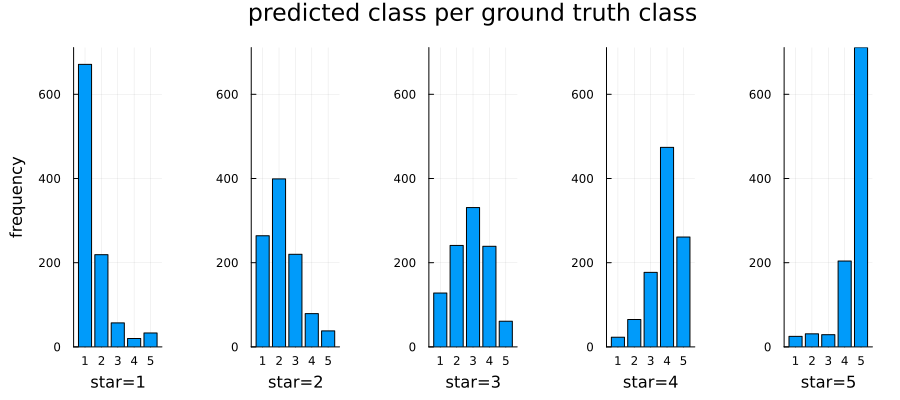

In [ ]:
canvases = []
label_names = 1:5
for gt_star in 1:5
    idxs = labels_test .== gt_star
    value_counts = [sum((y_pred[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="star=$gt_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="predicted class per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "prediction_star.png"))
p

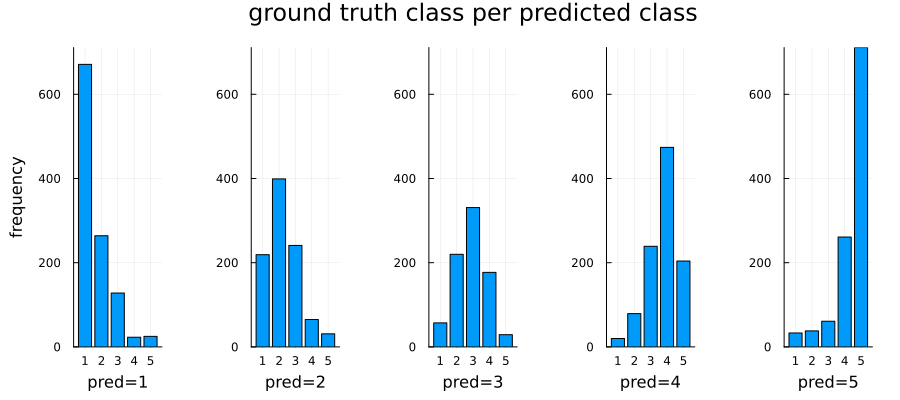

In [ ]:
canvases = []
label_names = 1:5
for pred_star in 1:5
    idxs = y_pred .== pred_star
    value_counts = [sum((labels_test[idxs]) .== l) for l in 1:nlabels]
    p = bar(value_counts, xlabel="pred=$pred_star",legend=:none, xticks=(1:nlabels, 1:5))#["neg", "mix", "pos"]))
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="ground truth class per predicted class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "star_prediction.png"))
p

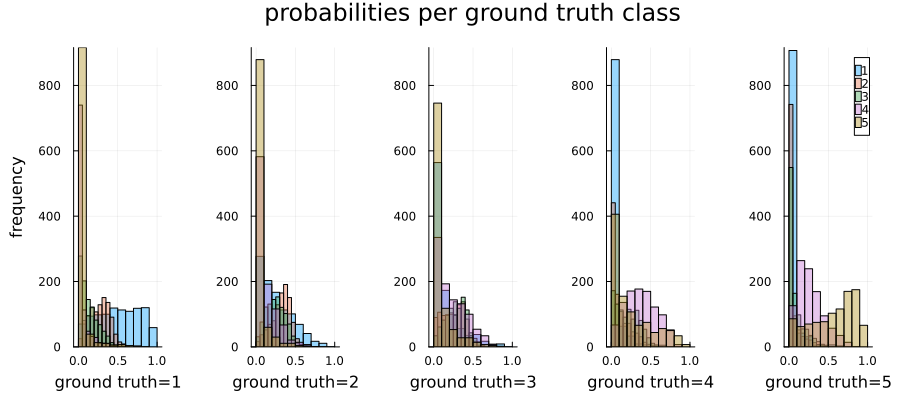

In [ ]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        histogram!(probs_star[pred_star, :], fillalpha=0.4, label=label_names[pred_star], nbins=12)
    end
    push!(canvases, p)
end
plot!(canvases[1], ylabel="frequency")
plot!(canvases[5], legend=:best)
p =plot(canvases..., layout=(1, 5), link=:y, size=(900, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star.png"))
p

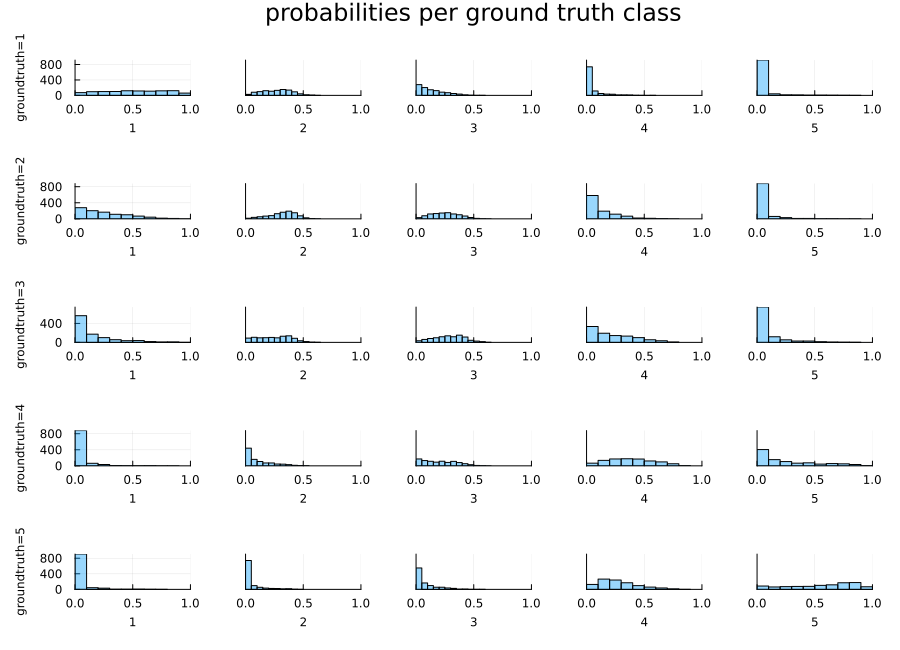

In [ ]:
canvases = []
label_names = 1:5
for groundtruth_star in 1:5
    idxs = labels_test .== groundtruth_star
    probs_star = probs[:, idxs]
    #p = plot(xlabel="ground truth=$groundtruth_star", legend=:none, xticks=([0.00, 0.50, 1.00]))
    for pred_star in 1:nlabels
        p = histogram(probs_star[pred_star, :], fillalpha=0.4, label="", nbins=12,  
            xlims=[0, 1], xticks=([0.00, 0.50, 1.00]), yticks=([]), xlabel="$pred_star", xguidefontsize=8)
        push!(canvases, p)
    end
end

for groundtruth_star in 1:5
    plot!(canvases[1 + 5 * (groundtruth_star - 1)], ylabel="groundtruth=$groundtruth_star", yguidefontsize=8,
        yticks=([0, 400, 800])
    )
end
    
p =plot(canvases..., layout=(5, 5), link=:y, size=(900, 650), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilites_star_grid.png"))
p

### Single sample

In [ ]:
idx = 4600 

d = documents_test[idx]
println(labels_test[idx])
println(d)
println("")

tokens = preprocess(d, tokenizer; max_length=50)
println(join(tokens, "|"))
println("")

x = indexer(tokens)
x = vcat(x, ones(Int, 50 - length(x)))
println(join(x, "|"))

5
I used for a party and was great !

used|for|party|and|was|great

84|6|776|3|14|25|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1


In [ ]:
model.embed(x)

32×50 Matrix{Float32}:
  0.854022   -0.433289    0.684625  …  -0.20657    -0.20657    -0.20657
  0.0587912  -0.0579329   0.567125      0.289418    0.289418    0.289418
  0.524547   -1.12711    -1.11666      -0.256261   -0.256261   -0.256261
  0.889912    0.198377   -1.10068      -0.455312   -0.455312   -0.455312
 -0.366376   -0.569984   -2.94602       0.82137     0.82137     0.82137
 -0.395074    0.107257    0.381777  …  -0.202711   -0.202711   -0.202711
 -0.823305   -0.665288    0.390934      0.781209    0.781209    0.781209
 -0.832479   -0.117937    0.195753     -0.36442    -0.36442    -0.36442
 -0.83288     0.145225   -0.922448     -0.235195   -0.235195   -0.235195
 -1.75994    -0.636442    1.16538       0.151554    0.151554    0.151554
  0.806757    1.79428     0.815358  …   1.19571     1.19571     1.19571
  0.881971   -0.44892    -0.488774      0.405805    0.405805    0.405805
  1.02029     1.11779    -0.309046     -1.10789    -1.10789    -1.10789
  ⋮                              

In [ ]:
softmax(model(x))

5×1 Matrix{Float32}:
 0.007808626
 0.016828882
 0.0406566
 0.25800982
 0.67669606